<a href="https://colab.research.google.com/github/Solo7602/MADPA/blob/main/7labFull12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Generate BERT embedding...


BERT embedding: 100%|██████████| 10000/10000 [15:58<00:00, 10.43it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


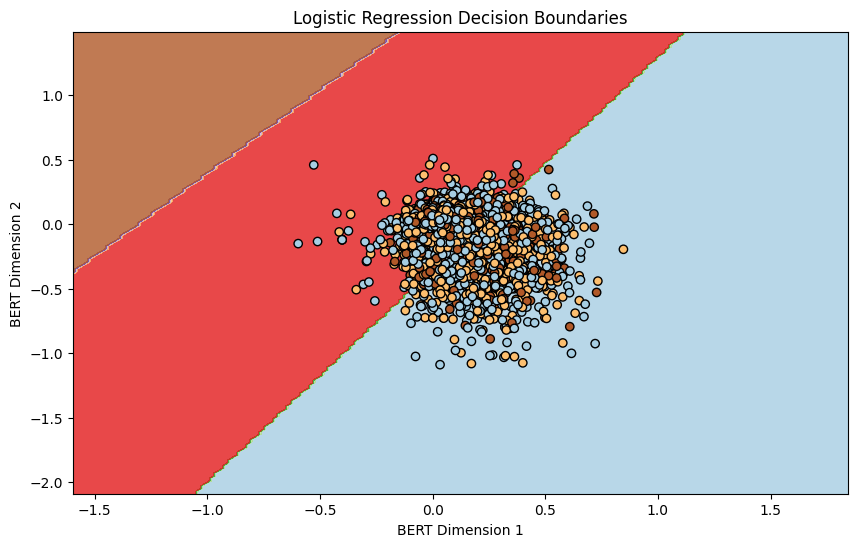

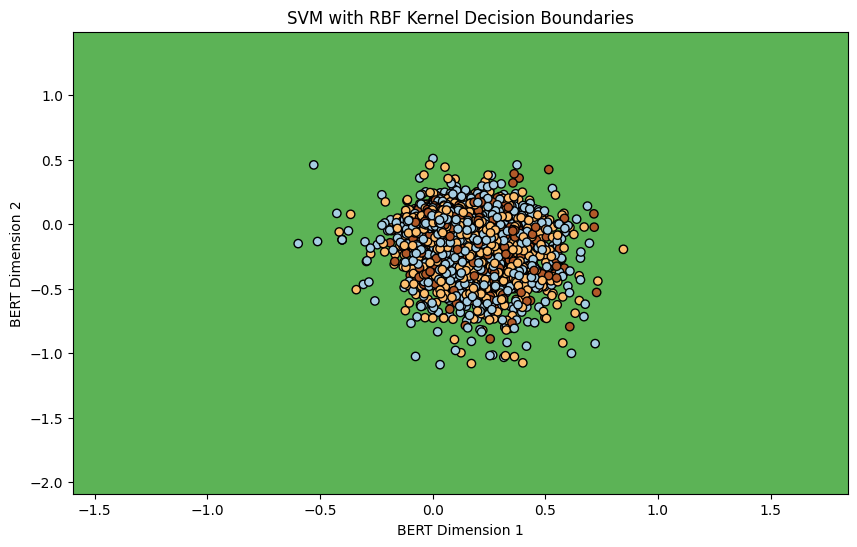

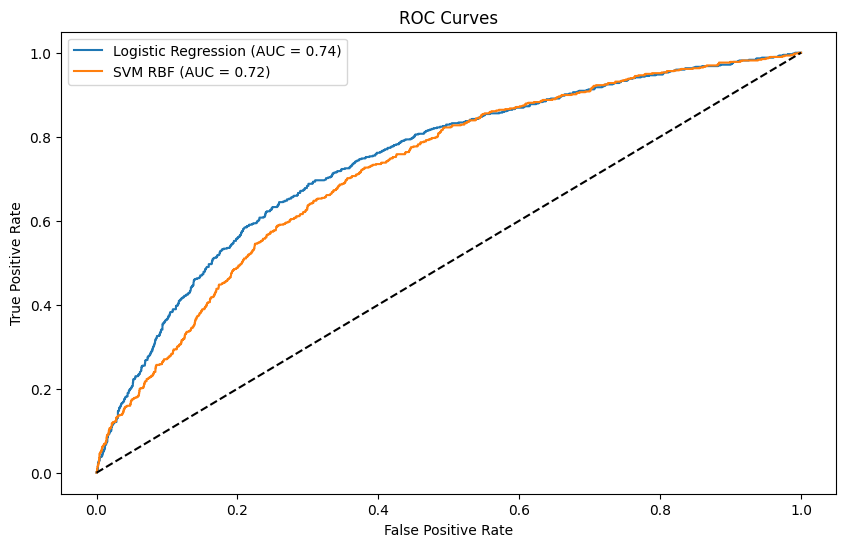


Сравнение моделей:
                 Model  Accuracy  F1-score
0  Logistic Regression  0.540000  0.520090
4              SVM RBF  0.539000  0.489936
1           Linear SVM  0.538333  0.520327
3             SVM Poly  0.525333  0.455948
2           Perceptron  0.521000  0.472043


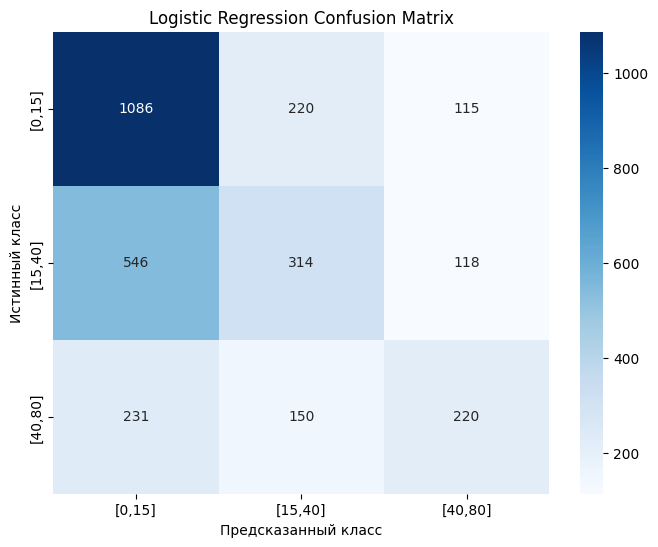

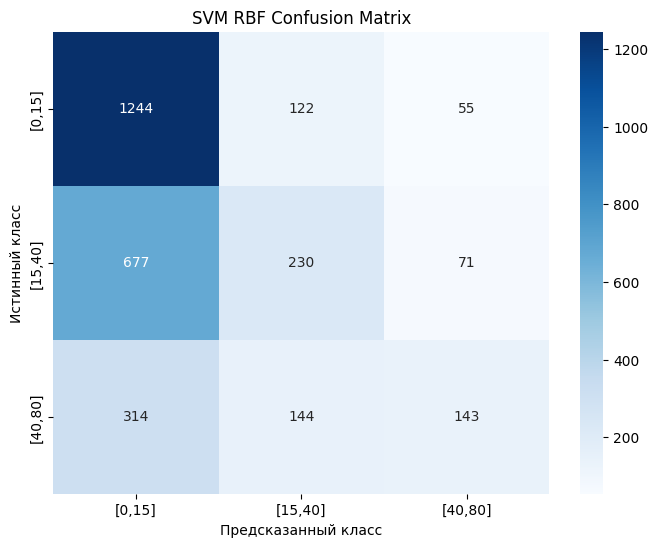

In [2]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tqdm import tqdm
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import cross_val_score, StratifiedKFold
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve, classification_report


# Загрузка данных
#Цель обучить модель с помощью Logistic Regresion, Линейсный SVM, Перцептроп
data = pd.read_csv('all_dataset_processed.csv').head(10000)

# data = data_long.head(2000)

numeric_features = ['Spell_Errors', 'Slang_Count', 'Emoji_Count', 'Punctuation_Count', 'Word_Count', 'Avg_Word_Length', 'Comment_Length', 'Ends_With_Punct', 'Has_Slang', 'Has_Spell_Errors']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numeric_features]).astype(int)

# BERT эмбеддинги
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

bert_file = 'bert_embeddings_40к.npy'

if os.path.exists(bert_file):
    print("Load Saving BERT embedding...")
    bert_features = np.load(bert_file)
else:
    print("Generate BERT embedding...")
    bert_embeddings = []
    for comment in tqdm(data['Comment_processed'], desc="BERT embedding"):
        try:
            emb = get_bert_embedding(comment)
        except Exception:
            emb = np.zeros(768)
        bert_embeddings.append(emb)

    bert_features = np.vstack(bert_embeddings)
    np.save(bert_file, bert_features)  # Сохраняем в файл


# Объединение признаков
X = np.hstack([bert_features, scaled_features])

y = data['Age_Group'].values

# Разделение данных
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



# 1. Логистическая регрессия
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# 2. Линейный SVM
linear_svm = LinearSVC(max_iter=100)
linear_svm.fit(X_train_scaled, y_train)
y_pred_svm = linear_svm.predict(X_test_scaled)

# 3. Перцептрон
perceptron = Perceptron(max_iter=1000, tol=1e-3)
perceptron.fit(X_train_scaled, y_train)
y_pred_perc = perceptron.predict(X_test_scaled)

# 4. SVM с различными ядрами
# Полиномиальное ядро
param_grid_poly = {'C': [0.1, 1], 'degree': [2, 3], 'kernel': ['poly']}
svm_poly = GridSearchCV(SVC(), param_grid_poly, cv=5, scoring='accuracy')
svm_poly.fit(X_train_scaled, y_train)
y_pred_poly = svm_poly.predict(X_test_scaled)

# RBF ядро
param_grid_rbf = {'C': [0.1, 1], 'gamma': [0.1, 1, 'scale', 'auto'], 'kernel': ['rbf']}
svm_rbf = GridSearchCV(SVC(), param_grid_rbf, cv=5, scoring='accuracy')
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)

# Визуализация границ решений
def plot_decision_boundary(model, X, y, title):
    # Берем только первые 2 признака из BERT-эмбеддингов для визуализации
    X_vis = X[:, :2]  # Первые два измерения BERT

    h = 0.02
    x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
    y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Создаем фиктивные признаки для остальных измерений
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    # Добавляем средние значения для остальных признаков
    dummy_features = np.zeros((mesh_points.shape[0], X.shape[1] - 2))
    mesh_points = np.hstack([mesh_points, dummy_features])

    # Предсказание
    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('BERT Dimension 1')
    plt.ylabel('BERT Dimension 2')
    plt.title(title)
    plt.show()

plot_decision_boundary(log_reg, X_train_scaled, y_train, "Logistic Regression Decision Boundaries")
plot_decision_boundary(svm_rbf.best_estimator_, X_train_scaled, y_train, "SVM with RBF Kernel Decision Boundaries")

# ROC-кривые для бинарной классификации
y_binary = np.where(y == 2, 1, 0)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.3, random_state=42)

log_reg_bin = LogisticRegression(max_iter=1000)
log_reg_bin.fit(X_train_bin, y_train_bin)

svm_rbf_bin = SVC(kernel='rbf', probability=True)
svm_rbf_bin.fit(X_train_bin, y_train_bin)

plt.figure(figsize=(10, 6))
y_prob_log = log_reg_bin.predict_proba(X_test_bin)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test_bin, y_prob_log)
roc_auc_log = roc_auc_score(y_test_bin, y_prob_log)
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')

y_prob_svm = svm_rbf_bin.predict_proba(X_test_bin)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin, y_prob_svm)
roc_auc_svm = roc_auc_score(y_test_bin, y_prob_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM RBF (AUC = {roc_auc_svm:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Сравнение моделей
models = {
    'Logistic Regression': y_pred_log,
    'Linear SVM': y_pred_svm,
    'Perceptron': y_pred_perc,
    'SVM Poly': y_pred_poly,
    'SVM RBF': y_pred_rbf
}

results = []
for name, y_pred in models.items():
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred, average='weighted')
    })

results_df = pd.DataFrame(results)
print("\nСравнение моделей:")
print(results_df.sort_values(by='Accuracy', ascending=False))

# Матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['[0,15]', '[15,40]', '[40,80]'],
                yticklabels=['[0,15]', '[15,40]', '[40,80]'])
    plt.title(title)
    plt.ylabel('Истинный класс')
    plt.xlabel('Предсказанный класс')
    plt.show()

plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_rbf, "SVM RBF Confusion Matrix")